In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

from TE import transfer_entropy

# Transfer Entropy between timeseries
 
In this notebook we compute the transfer entropy (TE) between an auto-correlated time series Y and a derived time series X, assessing how different weight contributions from Y affect the value of the TE. TE(Y->X) is computed using `transfer_entropy(X, Y, delay)`, present in `TE.py`, to assess how relevant the information in Y, observed at a time delay `delay`, is in predicting future values of X.

## Generating Time Series:

- Y is generated as an auto-correlated time series using an AR(1) process, meaning each value depends on the previous one with some added noise and an AR coefficient `ar_coefficient`.  
- K is generated as an independent noise series with no auto-correlation.

- X is then computed as a lagged and noisy linear combination of Y and K:

    - $ X[t] = W_Y \cdot Y[t-T_{LAG}] + (1- W_Y) \cdot K[t-T_{LAG}] $
    - The $T_{LAG}$ determines the time lag with which X is generated as a shifted version of Y and K.
    - The weight parameter $W_{Y}$ determines how much Y contributes to X.

In [2]:
def stochastic_timeseries(W_Y, T_LAG = 3, length=1000, noise_level=0.01, ar_coeff=0.8):
    """
    generate time series where Y is an auto-correlated series, K is independent and non correlated,
    and X is a lagged and noisy combination of Y and K.
    
    params:
    - W_Y: Weight for Y in determining X.
    - length: length of the time series.
    - noise_level: std of the gaussian noise.
    - ar_coeff: coefficient for AR(1) process of Y.
    
    returns:
    - X, Y, K: generated time series.
    """
    np.random.seed(42)
    
    # Generate auto-correlated Y
    Y = np.zeros(length)
    Y[0] = np.random.randn()
    for t in range(1, length):
        Y[t] = ar_coeff * Y[t-1] + np.random.randn()
    
    # Generate independent noise series K
    K = np.random.randn(length)
    
    # Compute X as a lagged and noisy combination of Y and K
    W_K = 1. - W_Y
    X = W_Y * np.roll(Y, shift=3) + W_K * np.roll(K, shift=T_LAG) + noise_level * np.random.randn(length)
    
    return X, Y, K

## Testing Transfer Entropy:  

- **Plot [1]** :As the weight $W_Y$ increases (the amount of information from Y to X), we obtain lower values of Transfer Entropy, indicating a higher capability of predicting future values of X.
- **Plot [2]** :We show that comparing different `delay` values at which TE is evaluated also allows to find the $T_{LAG}$ used to generate X as a shifted and weighted version of Y

## [1] Plot 1

- The following analysis shows six different cases where $W_{Y}$ increases from 0.1 to 1.  
- Higher $W_Y$ (stronger influence of Y on X) corresponds to higher opacity in the plot.  
- As $W_Y$ increases, TE(Y → X) decreases, meaning that Y becomes a stronger predictor of X, which is expected because X is constructed from a weighted delayed version of Y.
- The 'delay' parameter is set here as 'delay = $T_{LAG}$ = 3' to instead focus on the effect of different $W_{Y}$ values



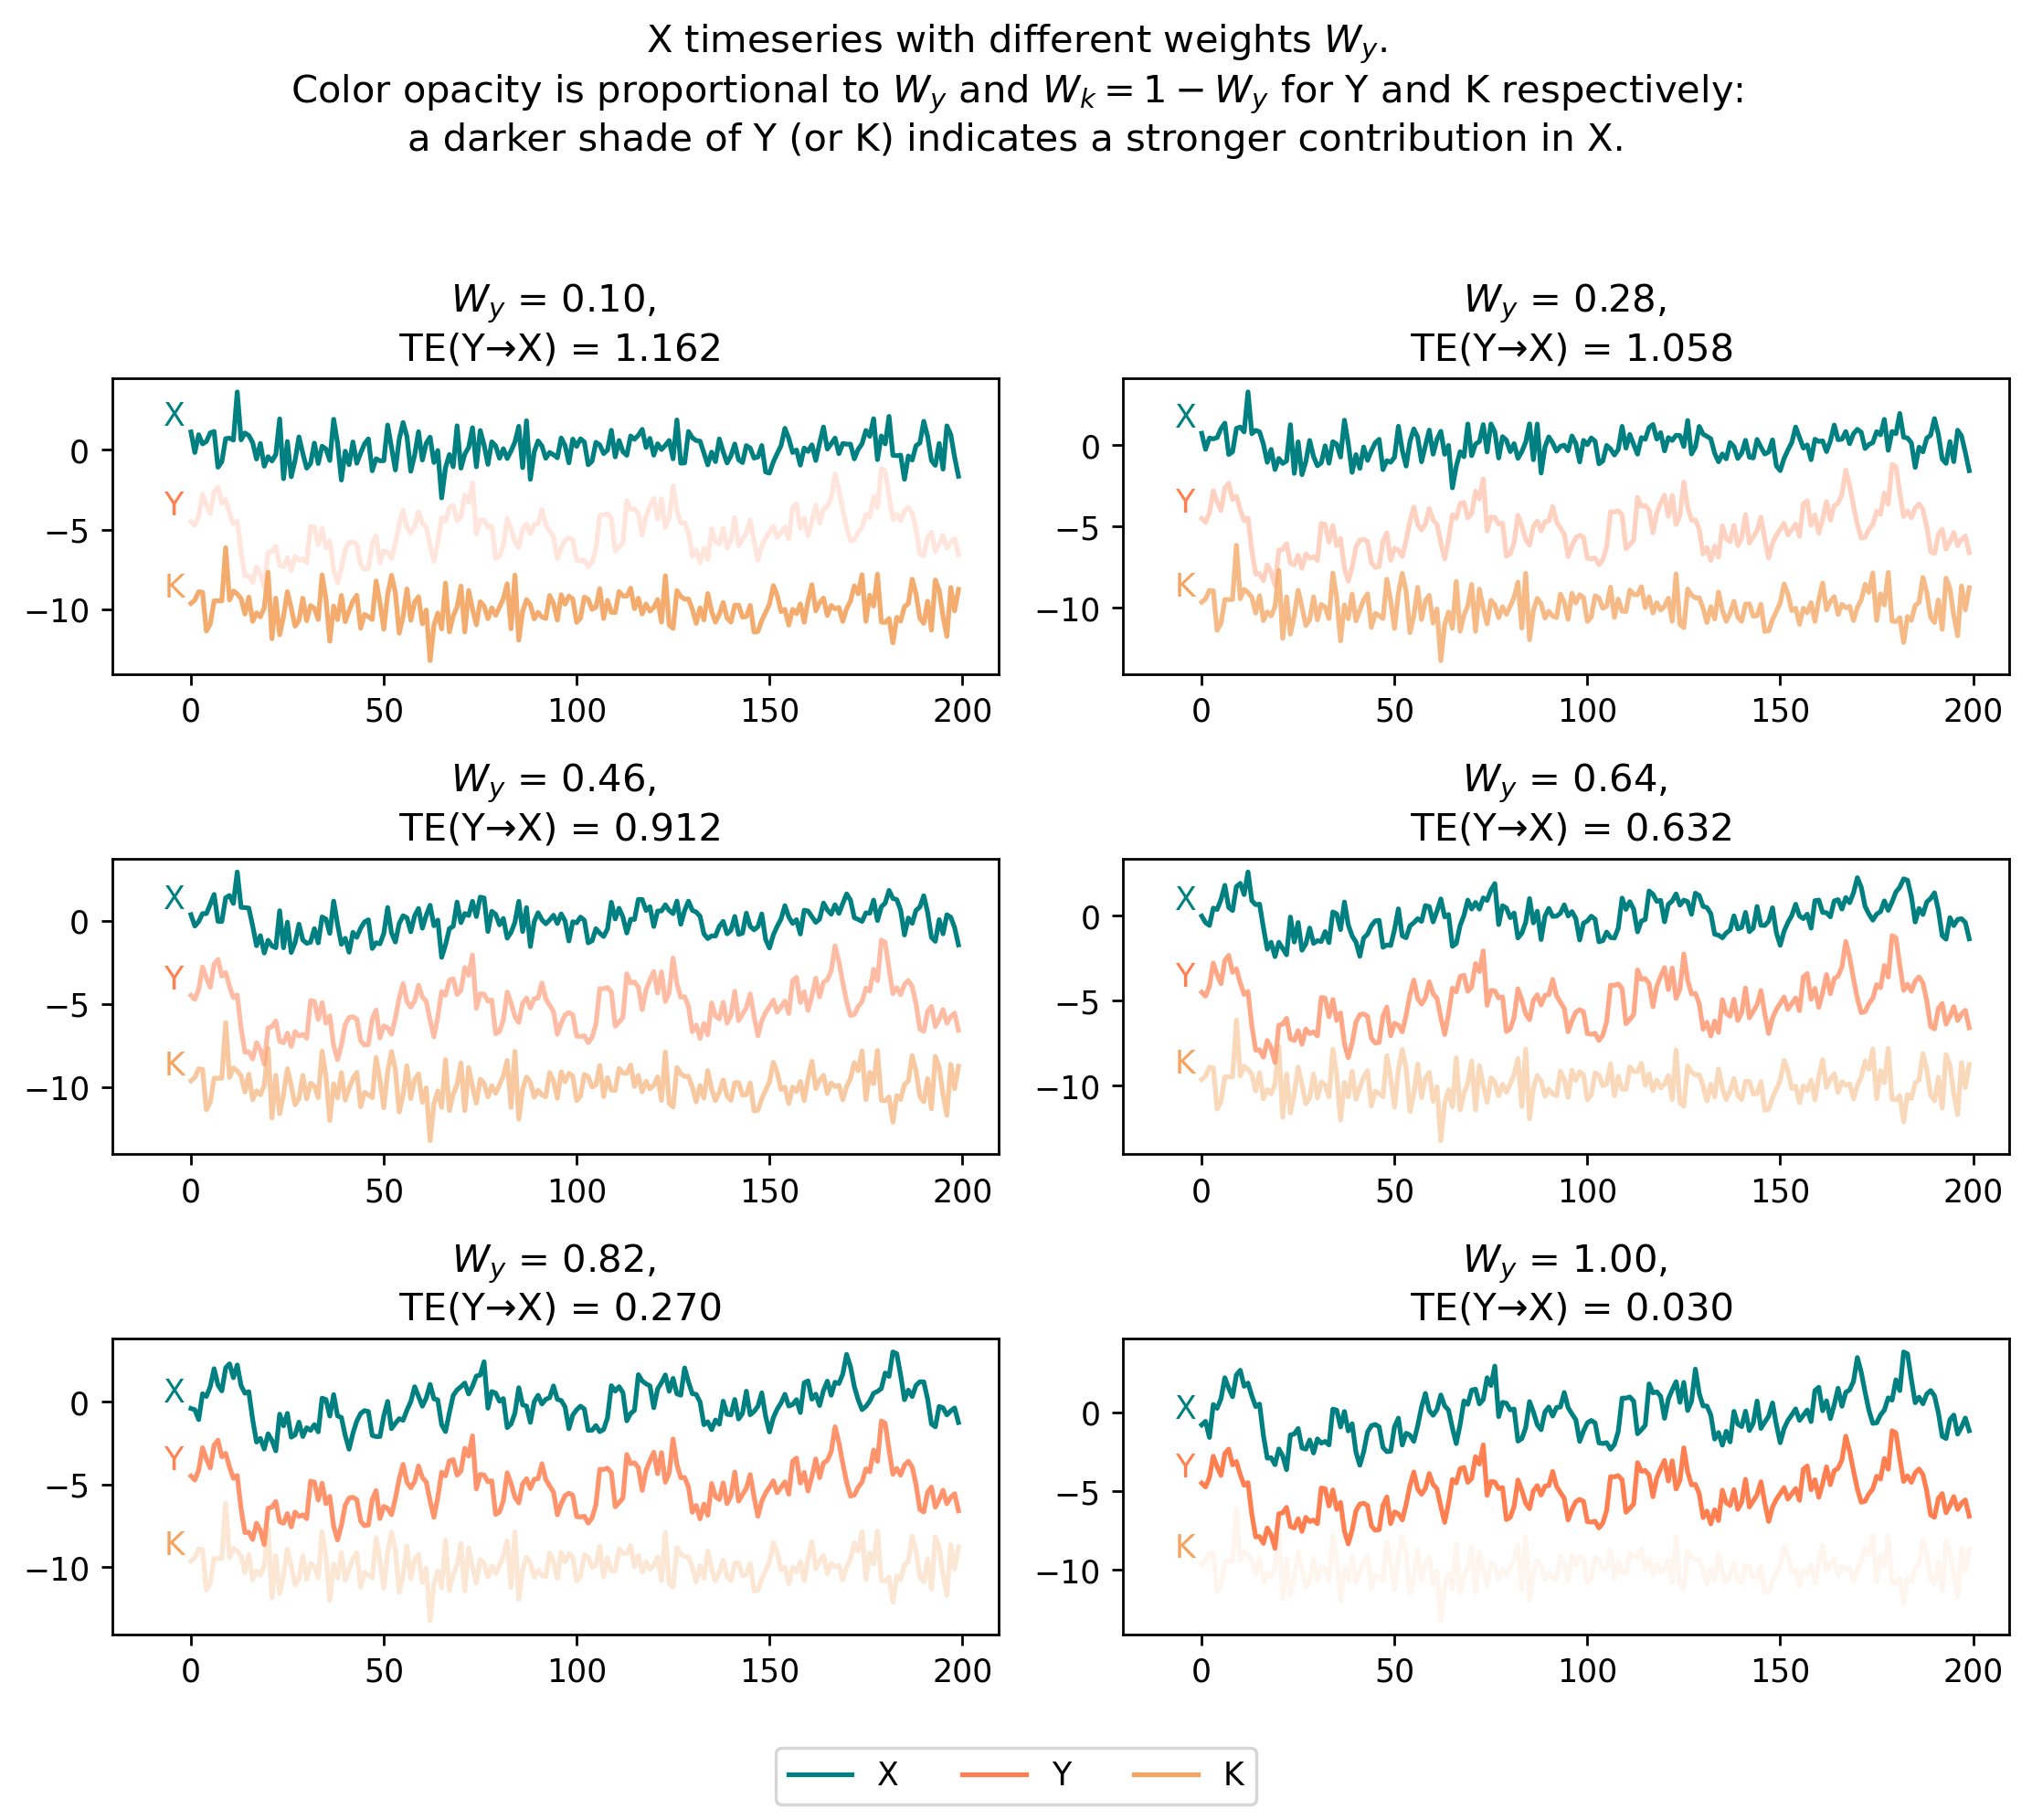

In [3]:
def plot_timeseries_with_TE():
    W_Y_values = np.linspace(0.1, 1, 6)
    length = 200
    
    fig, axes = plt.subplots(3, 2, figsize=(9, 8), dpi=250)
    axes = axes.flatten()
    
    for i, W_Y in enumerate(W_Y_values):
        X, Y, K = stochastic_timeseries(W_Y, length=length)
        TE_YX = transfer_entropy(X, Y, delay=3)
        
        axes[i].plot(X, label='X', color='teal', alpha=1.0)
        axes[i].plot(Y - 5, color='coral', alpha=W_Y)
        axes[i].plot(Y - 5, label='Y', color='coral', alpha=0.1)
        axes[i].plot(K - 10, color='sandybrown', alpha=1 - W_Y)
        axes[i].plot(K - 10, color='sandybrown', label='K', alpha=0.1)
        axes[i].plot(np.arange(-10, 0), np.ones(10), color='white', alpha=0.0)
        
        # Add labels at the beginning of each time series
        axes[i].text(-7, X[0], 'X', color='teal', verticalalignment='bottom')
        axes[i].text(-7, Y[0] - 5, 'Y', color='coral', verticalalignment='bottom')
        axes[i].text(-7, K[0] - 10, 'K', color='sandybrown', verticalalignment='bottom')
        
        axes[i].set_title(fr'$W_y$' + f' = {W_Y:.2f}, \n TE(Y→X) = {TE_YX:.3f}')

    handles = [
        plt.Line2D([0], [0], color='teal', label='X'),
        plt.Line2D([0], [0], color='coral', label='Y'),
        plt.Line2D([0], [0], color='sandybrown', label='K')
    ]
    
    fig.legend(handles=handles, loc='lower center', ncol=3)
    
    # Set the main title over the entire plot
    fig.suptitle(
        r"X timeseries with different weights $W_{y}$."+"\n"
        r"Color opacity is proportional to $W_{y}$ and $W_{k} = 1-W_{y}$ for Y and K respectively:" + "\n"
        r"a darker shade of Y (or K) indicates a stronger contribution in X.",
        fontsize=12
    )
    
    plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    plt.show()


# plot
plot_timeseries_with_TE()



## [2] Plot 2 (Transfer Entropy vs Delay parameter)

- Transfer entropy is the lowest when the `delay` used to evaluate the TE between X and Y coincides to the $T_{LAG}$ used to generate X from Y, as expected.
- Here X is a rolled version of Y with a delay of 3, the choice of delay in evaluating TE is crucial. TE statistic can therefore be used to uncover at which time lag Y influences X (delay at which TE is the lowest).
- Here we are also using Y as an autocorrelated timeseries, therefore also at `delay $\approx T_{LAG}$` we still observe a lower TE


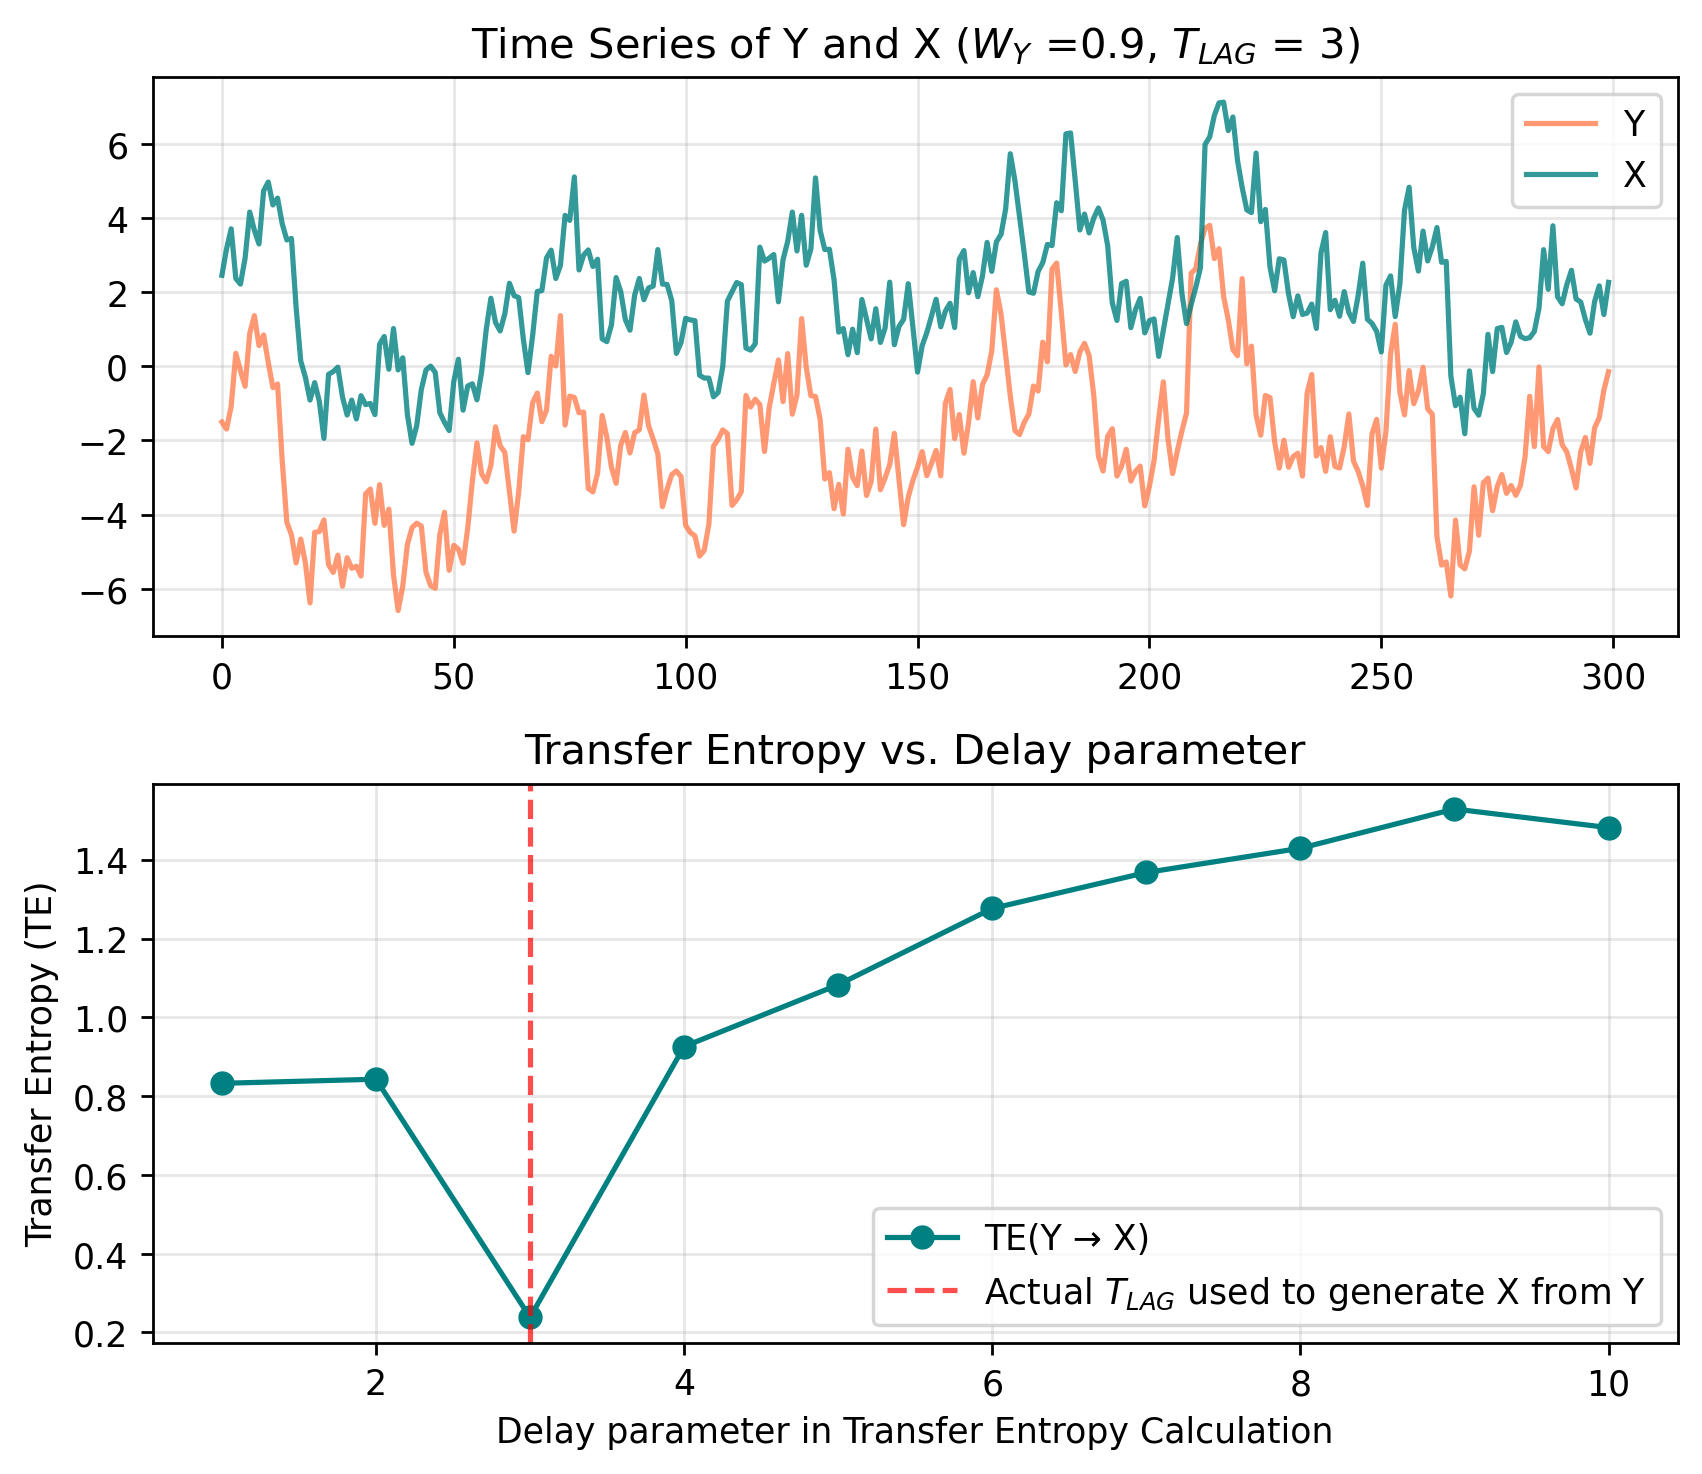

In [4]:

def plot_TE_vs_delay(W_Y=0.9, max_delay=10):
    X, Y, K = stochastic_timeseries(W_Y, length=300, noise_level=0.01, ar_coeff=0.9)
    
    delays = np.arange(1, max_delay + 1)
    TE_values = [transfer_entropy(X, Y, delay=d) for d in delays]  # Compute TE for each delay


    fig, axes = plt.subplots(2, 1, figsize=(7, 6), dpi=250, gridspec_kw={'height_ratios': [1, 1]})
    

    axes[0].plot(Y - 2, label='Y', color='coral', alpha=0.8)  # shift Y for better visualization
    axes[0].plot(X + 2, label='X', color='teal', alpha=0.8)  # shift X for better visualization
    axes[0].set_title(r'Time Series of Y and X ($W_{Y}$ ='+ f'{W_Y},'+ r' $T_{LAG}$ = 3)')
    axes[0].legend()
    axes[0].grid(alpha=0.3)


    axes[1].plot(delays, TE_values, marker='o', linestyle='-', color='teal', label='TE(Y → X)')
    axes[1].axvline(3, color='red', linestyle='--', alpha=0.7, label=r'Actual $T_{LAG}$ used to generate X from Y')
    
    axes[1].set_xlabel('Delay parameter in Transfer Entropy Calculation')
    axes[1].set_ylabel('Transfer Entropy (TE)')
    axes[1].set_title(f'Transfer Entropy vs. Delay parameter')
    axes[1].legend()
    axes[1].grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

# plot
plot_TE_vs_delay()
